In [107]:
from tempo_detector import TempoDetector
import io_utils
import matplotlib.pyplot as plt
import numpy as np

In [41]:
TEST_BUCKETS = [(1.0/64,), (1.0/32,), (1.0/32, 'd'), (1.0/32, 't'), (1.0/16, 'd'), (1.0/16, 't'), (1.0/16,),
                (1.0/8, 'd'), (1.0/8, 't'), (1.0/8,),
                (1.0/4, 'd'), (1.0/4, 't'), (1.0/4,),
                (1.0/2, 'd'), (1.0/2,),
                (1.0,), (2.0,), (3.0,), (4.0,), (5.0,)]

# SIMPLE_BUCKETS = TEST_BUCKETS
SIMPLE_BUCKETS = [(1.0/32,),  (1.0/16, 't'), (1.0/16, 'd'), (1.0/16,),
                (1.0/8, 'd'), (1.0/8, 't'), (1.0/8,),
                (1.0/4, 'd'), (1.0/4, 't'), (1.0/4,),
                (1.0/2, 'd'), (1.0/2,),
                (1.0,)]

In [81]:
DIRS = ['debussy', 'mozart', 'beeth', 'chopin', 'bach']
# DIRS = ['mozart']
OUTPUT_DIR = 'predicted_tempos'
START_TEMPOS = range(40, 200, 40)

In [51]:
def predictTempos(E_time_mat, detector):
    predicted_tempos = []
    for i in range(len(E_time_mat)):
        if i % 5 == 0:
            print i, '/', len(E_time_mat)
        detector.setBuckets(TEST_BUCKETS)
        candidates_with_losses = [detector.predict(E_time_mat[i], t, detector.linearDistanceFunction, \
                            detector.linearDistanceFunctionGradient, lambda x: 1) for t in START_TEMPOS]
        candidates_with_losses = list(set(candidates_with_losses))
        print candidates_with_losses
        candidates = [c for c, l in candidates_with_losses]
        E_pred_mat, sigs = io_utils.generatePredictedTempoMatrix(filenames[i], TEST_BUCKETS, candidates)
        detector.setBuckets(SIMPLE_BUCKETS)
        candidates_bucketed_loss = [(c, detector.computeLoss(c, E_time_mat[i], detector.logDistanceFunction)) \
                                       for c in candidates]
        tempo_options = sorted(candidates_bucketed_loss, key=lambda x: x[1])
        predicted_tempos.append([tempo_options[i][0] for i in range(len(tempo_options))])
    return predicted_tempos

In [93]:
def compareTempos(predicted_tempos, actual_tempos):
    comparison = []
    predicted_tempos = [int(t) for t in predicted_tempos]
    actual_tempos = [int(t) for t in actual_tempos]
    for i in range(len(predicted_tempos)):
        absolute_diff = abs(predicted_tempos[i] - actual_tempos[i])
        pred_over_actual = predicted_tempos[i] / actual_tempos[i]
        if pred_over_actual > 0:
            scale = pred_over_actual
            scaled_diff = min(abs(predicted_tempos[i] - actual_tempos[i] * scale), \
                              abs(predicted_tempos[i] - actual_tempos[i] * (scale+1)))
        else:
            scale = actual_tempos[i] / predicted_tempos[i]
            scaled_diff = min(abs(actual_tempos[i] - scale * predicted_tempos[i]), \
                              abs(actual_tempos[i] - (scale+1) * predicted_tempos[i]))
        comparison.append((absolute_diff, scale, scaled_diff, predicted_tempos[i], actual_tempos[i]))
    return comparison

def compareTempoCandidates(predicted_candidates, actual_tempos, n, max_percent_diff):
    n_in_max_diff = 0
    for i in range(len(predicted_candidates)):
        min_diff = min(abs(float(t) / actual_tempos[i] - 1) for t in predicted_candidates[i][:n])
        print actual_tempos[i]
        print min_diff
        if min_diff < max_percent_diff:
            n_in_max_diff += 1
    return float(n_in_max_diff) / len(predicted_candidates)

def generateRankedByLog(candidate_tempos, E_time_mat, detector):
    tempos = []
    for i in range(len(candidate_tempos)):
        ranked_by_log = [(t, detector.computeLoss(t, E_time_mat[i], detector.logDistanceFunction)) for t in candidate_tempos[i]]
        ranked_by_log = sorted(ranked_by_log, key=lambda x: x[1])
        ranked_by_log = [t for t, l in ranked_by_log]
        tempos.append(ranked_by_log)
    return tempos

In [82]:
E_time_mat, tempos, filenames = io_utils.generateTempoPredictionData(DIRS)
detector = TempoDetector(TEST_BUCKETS)
predicted_tempos = predictTempos(E_time_mat, detector)

[25.0, 50.0, 75.0, 33.33333333333333, 150.0, 66.66666666666666, 100.0, 300.0, 133.33333333333331, 200.0, 600.0, 266.66666666666663, 400.0, 1200.0, 800.0, 1600.0, 3200.0, 4800.0, 6400.0, 8000.0]
0 / 110
[(141, 4000254), (68, 834210), (34, 65477), (94, 653566)]
[(134, 625547), (70, 216124), (155, 1203099), (81, 375775)]
[(86, 152708), (44, 47180), (169, 2789108), (119, 264802)]
[(153, 1679232), (111, 371778), (77, 125176), (41, 44708)]
[(160, 688808), (124, 93089), (81, 59740), (44, 42235)]
5 / 110
[(151, 1285876), (108, 263311), (57, 112694), (76, 215731)]
[(41, 704349), (94, 94026), (131, 791105), (172, 3115102)]
[(47, 257556), (93, 1130286), (95, 1018887), (136, 3244847)]
[(91, 251080), (48, 127019), (136, 543325)]
[(163, 1254240), (85, 795932), (129, 3497337)]
10 / 110
[(92, 506809), (47, 214416), (135, 909056), (182, 1863736)]
[(110, 115212), (55, 103717), (75, 102547), (147, 145651)]
[(140, 1153901), (105, 314607)]
[(156, 2271794), (114, 1068533), (81, 719812)]
[(101, 458169), (52,

In [83]:
predicted_tempos

[[141, 94, 68, 34],
 [155, 134, 81, 70],
 [169, 119, 86, 44],
 [153, 111, 77, 41],
 [160, 124, 81, 44],
 [151, 108, 76, 57],
 [172, 131, 94, 41],
 [136, 95, 93, 47],
 [136, 91, 48],
 [163, 129, 85],
 [182, 135, 92, 47],
 [147, 110, 75, 55],
 [140, 105],
 [156, 114, 81],
 [134, 101, 52],
 [145, 108, 75, 38],
 [151, 108, 85, 44],
 [134, 92, 46],
 [172, 122, 85, 43],
 [146, 106, 75, 39],
 [142, 100],
 [180, 124, 88, 44],
 [171, 127, 86, 48],
 [149],
 [124, 104, 80, 54],
 [163, 120, 83, 44],
 [172, 111, 85, 38],
 [144, 109, 75],
 [179, 133, 90, 45],
 [142, 105, 72, 39],
 [154, 122, 81, 57],
 [139, 102, 70, 35],
 [81, 163, 40],
 [152, 110, 78, 40],
 [156, 110, 81, 40],
 [139, 105, 72, 54],
 [133, 66, 50],
 [136, 98, 68, 34],
 [176, 130, 90, 45],
 [134, 78, 37],
 [142, 106, 72, 37],
 [121, 86, 44],
 [166, 120, 82, 43],
 [151, 120, 76, 41],
 [160, 40, 80, 120],
 [161, 122, 83, 42],
 [162, 132],
 [100, 139, 72, 35],
 [150, 76, 52],
 [160, 40, 80, 120],
 [170, 123, 93, 42],
 [163, 119, 82, 42],

In [84]:
compareTempoCandidates(predicted_tempos, tempos, 3, .8)

76.9999781833
0.116882866667
93.5000335042
0.13369015
173.809765212
0.0276725833333
110.99990565
8.49999999941e-07
123.5200751
0.0038854
74.4900226822
0.0202708666667
125.070091364
0.0474126833333
104.070004423
0.0871529166667
135.769951394
0.0016944
159.650047097
0.0209831
46.3800021799
0.983613533333
146.300071199
0.0047842
134.549964008
0.0405056666667
150.990117697
0.0331802
67.0999834487
0.225037066667
73.6600319439
0.01819125
55.9299756705
0.5197575
46.4999848875
0.0107523666667
85.0000425
5.0000000007e-07
144.940139722
0.0073124
96.1700286106
0.039825
122.99996925
0.00813033333333
127.069915986
0.000550216666667
142.000071
0.04929525
65.8000074573
0.215805333333
163.000070633
4.33333333327e-07
56.8800172915
0.494373666667
140.829863442
0.0225104
45.1900127059
0.9915905
140.869871456
0.0080225
159.4998086
0.0344816
70.600029652
0.008499
20.9000028912
0.913875333333
152.300112448
0.00197053333333
108.430077058
0.0144786666667
69.00001725
0.043478
196.000287467
0.321429566667
69.17

0.9272727272727272

In [85]:
compareTempoCandidates(predicted_tempos, tempos, 5, .8)

76.9999781833
0.116882866667
93.5000335042
0.13369015
173.809765212
0.0276725833333
110.99990565
8.49999999941e-07
123.5200751
0.0038854
74.4900226822
0.0202708666667
125.070091364
0.0474126833333
104.070004423
0.0871529166667
135.769951394
0.0016944
159.650047097
0.0209831
46.3800021799
0.0133677833333
146.300071199
0.0047842
134.549964008
0.0405056666667
150.990117697
0.0331802
67.0999834487
0.225037066667
73.6600319439
0.01819125
55.9299756705
0.213302
46.4999848875
0.0107523666667
85.0000425
5.0000000007e-07
144.940139722
0.0073124
96.1700286106
0.039825
122.99996925
0.00813033333333
127.069915986
0.000550216666667
142.000071
0.04929525
65.8000074573
0.1793314
163.000070633
4.33333333327e-07
56.8800172915
0.331927066667
140.829863442
0.0225104
45.1900127059
0.00420475
140.869871456
0.0080225
159.4998086
0.0344816
70.600029652
0.008499
20.9000028912
0.913875333333
152.300112448
0.00197053333333
108.430077058
0.0144786666667
69.00001725
0.043478
196.000287467
0.321429566667
69.179975

0.9636363636363636

In [101]:
compareTempoCandidates(rbl, tempos, 5, .8)

76.9999781833
0.116882866667
93.5000335042
0.13369015
173.809765212
0.0276725833333
110.99990565
8.49999999941e-07
123.5200751
0.0038854
74.4900226822
0.0202708666667
125.070091364
0.0474126833333
104.070004423
0.0871529166667
135.769951394
0.0016944
159.650047097
0.0209831
46.3800021799
0.0133677833333
146.300071199
0.0047842
134.549964008
0.0405056666667
150.990117697
0.0331802
67.0999834487
0.225037066667
73.6600319439
0.01819125
55.9299756705
0.213302
46.4999848875
0.0107523666667
85.0000425
5.0000000007e-07
144.940139722
0.0073124
96.1700286106
0.039825
122.99996925
0.00813033333333
127.069915986
0.000550216666667
142.000071
0.04929525
65.8000074573
0.1793314
163.000070633
4.33333333327e-07
56.8800172915
0.331927066667
140.829863442
0.0225104
45.1900127059
0.00420475
140.869871456
0.0080225
159.4998086
0.0344816
70.600029652
0.008499
20.9000028912
0.913875333333
152.300112448
0.00197053333333
108.430077058
0.0144786666667
69.00001725
0.043478
196.000287467
0.321429566667
69.179975

0.9636363636363636

In [120]:
tempo_success = [compareTempoCandidates(predicted_tempos, tempos, i, .8) for i in range(1, 7)]
print tempo_success

76.9999781833
0.83116935
93.5000335042
0.657753416667
173.809765212
0.0276725833333
110.99990565
0.37837955
123.5200751
0.295336
74.4900226822
1.02711711667
125.070091364
0.375228866667
104.070004423
0.306812666667
135.769951394
0.0016944
159.650047097
0.0209831
46.3800021799
2.92410503333
146.300071199
0.0047842
134.549964008
0.0405056666667
150.990117697
0.0331802
67.0999834487
0.997019866667
73.6600319439
0.968503083333
55.9299756705
1.6998045
46.4999848875
1.88172136667
85.0000425
1.0235284
144.940139722
0.0073124
96.1700286106
0.4765515
122.99996925
0.463415
127.069915986
0.34571585
142.000071
0.04929525
65.8000074573
0.884498266667
163.000070633
4.33333333327e-07
56.8800172915
2.02390906667
140.829863442
0.0225104
45.1900127059
2.96105221667
140.869871456
0.0080225
159.4998086
0.0344816
70.600029652
0.9688377
20.9000028912
2.87559755
152.300112448
0.00197053333333
108.430077058
0.4387152
69.00001725
1.01449225
196.000287467
0.321429566667
69.1799751644
0.9658868
179.890087157
0.0

In [49]:
print filenames

['mozart/mz_570_1.mid', 'mozart/mz_570_2.mid', 'mozart/mz_570_3.mid', 'mozart/mz_545_1.mid', 'mozart/mz_332_3.mid', 'mozart/mz_330_1.mid', 'mozart/mz_332_2.mid', 'mozart/mz_545_2.mid', 'mozart/mz_330_2.mid', 'mozart/mz_330_3.mid', 'mozart/mz_332_1.mid', 'mozart/mz_545_3.mid', 'mozart/mz_331_2.mid', 'mozart/mz_333_1.mid', 'mozart/mz_331_3.mid', 'mozart/mz_331_1.mid', 'mozart/mz_333_3.mid', 'mozart/mz_333_2.mid', 'mozart/mz_311_1.mid', 'mozart/mz_311_2.mid', 'mozart/mz_311_3.mid']


In [94]:
rbl = generateRankedByLog(predicted_tempos, E_time_mat, detector)

In [95]:
rbl

[[141, 94, 68, 34],
 [155, 134, 81, 70],
 [169, 119, 86, 44],
 [153, 111, 77, 41],
 [160, 124, 81, 44],
 [151, 108, 76, 57],
 [172, 131, 94, 41],
 [136, 95, 93, 47],
 [136, 91, 48],
 [163, 129, 85],
 [182, 135, 92, 47],
 [147, 110, 75, 55],
 [140, 105],
 [156, 114, 81],
 [134, 101, 52],
 [145, 108, 75, 38],
 [151, 108, 85, 44],
 [134, 92, 46],
 [172, 122, 85, 43],
 [146, 106, 75, 39],
 [142, 100],
 [180, 124, 88, 44],
 [171, 127, 86, 48],
 [149],
 [124, 104, 80, 54],
 [163, 120, 83, 44],
 [172, 111, 85, 38],
 [144, 109, 75],
 [179, 133, 90, 45],
 [142, 105, 72, 39],
 [154, 122, 81, 57],
 [139, 102, 70, 35],
 [81, 163, 40],
 [152, 110, 78, 40],
 [156, 110, 81, 40],
 [139, 105, 72, 54],
 [133, 66, 50],
 [136, 98, 68, 34],
 [176, 130, 90, 45],
 [134, 78, 37],
 [142, 106, 72, 37],
 [121, 86, 44],
 [166, 120, 82, 43],
 [151, 120, 76, 41],
 [160, 40, 80, 120],
 [161, 122, 83, 42],
 [162, 132],
 [100, 139, 72, 35],
 [150, 76, 52],
 [160, 40, 80, 120],
 [170, 123, 93, 42],
 [163, 119, 82, 42],

In [48]:
for i in range(len(predicted_tempos)):
            io_utils.eventListToMIDI(E_pred_mat[i], SIMPLE_BUCKETS, 400, \
                int(predicted_tempos[i]), filenames[i][:-4] + '_' + str(predicted_tempos[i]) + '.mid', OUTPUT_DIR, timeSig=sigs[i][0], keySig=sigs[i][1])

NameError: name 'E_pred_mat' is not defined

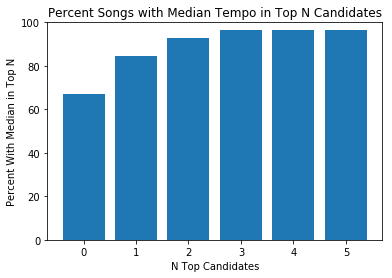

In [123]:
success_y = np.array(tempo_success)
x = np.arange(6)
success_y *= 100
plt.bar(x, success_y)
plt.title('Percent Songs with Median Tempo in Top N Candidates')
plt.xlabel('N Top Candidates')
plt.ylabel('Percent With Median in Top N')
axes = plt.gca()
axes.set_ylim([0, 100])
plt.xticks(np.arange(6))
plt.show()